In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

In [2]:
dataset3 = tf.keras.preprocessing.image_dataset_from_directory(directory='C:/brain_tumor/version2/classify_dataset/glioma', label_mode=None, batch_size=8, image_size=(256, 256), shuffle=True, color_mode='grayscale')
dataset3 = dataset3.map(lambda x: (x - 127.5) / 127.5)
dataset3 = dataset3.cache()
dataset3 = dataset3.prefetch(16)

Found 1534 files belonging to 1 classes.


In [4]:
dataset3.as_numpy_iterator().next().shape

(8, 256, 256, 1)

In [5]:
# generator
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose
from tensorflow import keras
from keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose
from keras.models import Sequential

def dc_generator():

    model = Sequential()

    model.add(Dense(16*16*256, input_dim=256))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(1, (4,4), strides=(2,2), padding='same',use_bias=False, activation='tanh'))
    
    return model

In [6]:
dc_generator = dc_generator()
dc_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      524288    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       131072    
 ranspose)                                              

In [7]:
image_dc = dc_generator.predict(np.random.randn(4, 256))
image_dc.shape

1/1 [==============================] - 6s 6s/step


(4, 256, 256, 1)

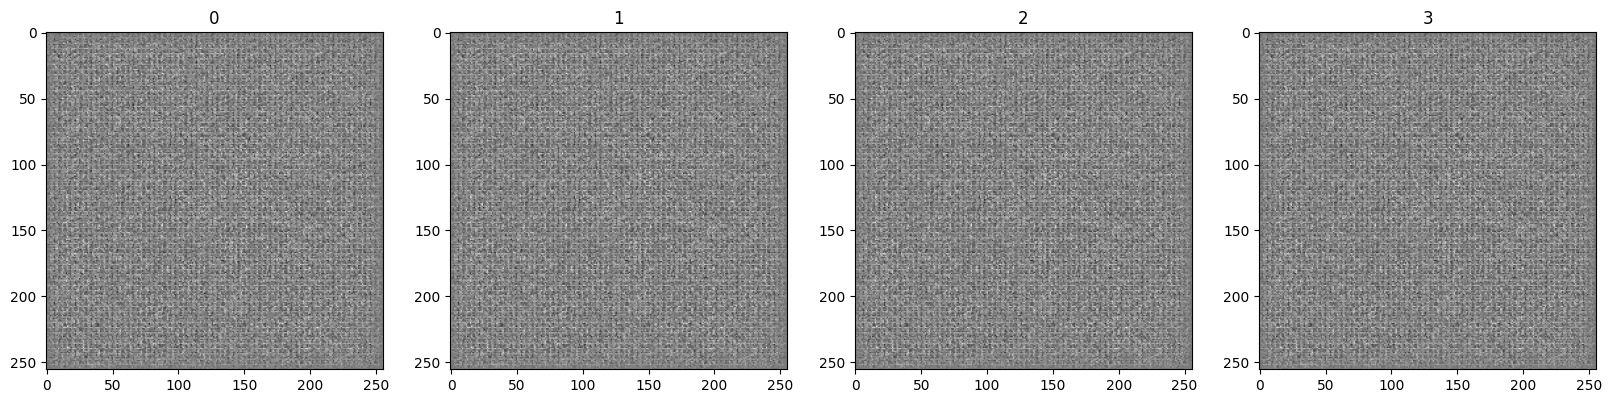

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(image_dc):
    for i in range(4):
        ax[idx].imshow(np.squeeze(image_dc[i]), cmap='gray')
        ax[idx].title.set_text(idx)

In [9]:
#discriminator
def dc_discriminator(input=(256,256,1)):

    model = Sequential()
    
    model.add(Conv2D(32, (4,4), strides=(2, 2), padding='same',input_shape=input))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, (4,4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, (4,4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, (4,4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [10]:
dc_discriminator = dc_discriminator()
dc_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      544       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                      

In [11]:
dc_discriminator.predict(image_dc)

1/1 [==============================] - 0s 165ms/step


array([[0.50000453],
       [0.49997997],
       [0.4999802 ],
       [0.49998486]], dtype=float32)

In [5]:
#training loop
from tensorflow import keras
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model
from keras.callbacks import Callback
import os
# from tensorflow.python.keras.optimizer_v1 import Adam
# from tensorflow.python.keras.losses import BinaryCrossentropy
# from tensorflow.python.keras.models import Model
# import os
# from tensorflow.python.keras.callbacks import Callback

dc_d_optimizer=Adam(lr=0.00003)
dc_g_optimizer=Adam(lr=0.0003)
d_loss=BinaryCrossentropy()
g_loss=BinaryCrossentropy()

# loss_fn=BinaryCrossentropy()
# dc_generator_optimizer = Adam(lr=0.0003)
# dc_discriminator_optimizer = Adam(lr=0.0001)
# dc_generator_loss = BinaryCrossentropy()
# dc_discriminator_loss = BinaryCrossentropy()

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
class DCGAN(Model):
    def __init__(self, dc_generator, dc_discriminator):
        super().__init__()
        self.dc_generator = dc_generator
        self.dc_discriminator = dc_discriminator
    #     self.g_loss_metric = keras.metrics.Mean(name='g_loss')
    #     self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    # @property
    # def metrics(self):
    #     return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, dc_g_optimizer, dc_d_optimizer, d_loss, g_loss):
        super(DCGAN, self).compile()
        self.dc_g_optimizer = dc_g_optimizer
        self.dc_d_optimizer = dc_d_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss
        # self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, 256))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.dc_discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels -= 0.15 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.d_loss(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.dc_generator(random_noise)
            pred_fake = self.dc_discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            fake_labels += 0.15 * tf.random.uniform(tf.shape(fake_labels))
            d_loss_fake = self.d_loss(fake_labels, pred_fake)
            
            # total discriminator loss
            dc_d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(dc_d_loss, self.dc_discriminator.trainable_variables)
        # update the gradients
        self.dc_d_optimizer.apply_gradients(zip(gradients, self.dc_discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.dc_generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.dc_discriminator(fake_images, training=True)
            # compute loss
            dc_g_loss = self.g_loss(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(dc_g_loss, self.dc_generator.trainable_variables)
        # update the gradients
        self.dc_g_optimizer.apply_gradients(zip(gradients, self.dc_generator.trainable_variables))
        
        # # update states for both models
        # self.d_loss_metric.update_state(dc_d_loss)
        # self.g_loss_metric.update_state(dc_g_loss)
        
        return {'d_loss': dc_d_loss, 'g_loss': dc_g_loss}

In [7]:
class DCGANMonitor(Callback):
    def __init__(self, num_imgs=3, latent_dim=256):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        # self.noise = tf.random.normal([4, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        noise = tf.random.normal([self.num_imgs, self.latent_dim])
        g_img = self.model.dc_generator(noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        fig = plt.figure(figsize=(20, 20))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = tf.keras.utils.array_to_img(g_img[i])
            # img.save(os.path.join('output_dcgan2', f'generated_img_from150_{epoch}_{i}.png'))
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

In [15]:
brain_tumor_dc = DCGAN(dc_generator, dc_discriminator)
brain_tumor_dc.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)

In [ ]:
N_EPOCHS = 50
brain_tumor_dc.fit(dataset3, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

In [17]:
dc_discriminator.save('try/dis1.h5')
dc_generator.save('try/gen1.h5')

In [ ]:
from keras.models import load_model
load_dc_generator1 = load_model('try/gen1.h5')
load_dc_discriminator1 = load_model('try/dis1.h5')
dc_model1 = DCGAN(load_dc_generator1, load_dc_discriminator1)
dc_model1.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist1 = dc_model1.fit(dataset3, epochs=100, callbacks=[DCGANMonitor()])

In [19]:
load_dc_discriminator1.save('try/dis2(150e).h5')
load_dc_generator1.save('try/gen2(150e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator2 = load_model('try/gen2(150e).h5')
load_dc_discriminator2 = load_model('try/dis2(150e).h5')
dc_model2 = DCGAN(load_dc_generator2, load_dc_discriminator2)
dc_model2.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist2 = dc_model2.fit(dataset3, epochs=100, callbacks=[DCGANMonitor()])

In [21]:
load_dc_discriminator2.save('try/dis3(250e).h5')
load_dc_generator2.save('try/gen3(250e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator3 = load_model('try/gen3(250e).h5')
load_dc_discriminator3 = load_model('try/dis3(250e).h5')
dc_model3 = DCGAN(load_dc_generator3, load_dc_discriminator3)
dc_model3.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist3 = dc_model3.fit(dataset3, epochs=100, callbacks=[DCGANMonitor()])

In [23]:
load_dc_discriminator3.save('try/dis4(350e).h5')
load_dc_generator3.save('try/gen4(350e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator4 = load_model('try/gen4(350e).h5')
load_dc_discriminator4 = load_model('try/dis4(350e).h5')
dc_model4 = DCGAN(load_dc_generator4, load_dc_discriminator4)
dc_model4.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist4 = dc_model4.fit(dataset3, epochs=100, callbacks=[DCGANMonitor()])

In [25]:
load_dc_discriminator4.save('try/dis5(450e).h5')
load_dc_generator4.save('try/gen5(450e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator5 = load_model('try/gen5(450e).h5')
load_dc_discriminator5 = load_model('try/dis5(450e).h5')
dc_model5 = DCGAN(load_dc_generator5, load_dc_discriminator5)
dc_model5.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist5 = dc_model5.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator5.save('try/dis6(650e).h5')
load_dc_generator5.save('try/gen6(650e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator6 = load_model('try/gen6(650e).h5')
load_dc_discriminator6 = load_model('try/dis6(650e).h5')
dc_model6 = DCGAN(load_dc_generator6, load_dc_discriminator6)
dc_model6.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist6 = dc_model6.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator6.save('try/dis7(850e).h5')
load_dc_generator6.save('try/gen7(850e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator7 = load_model('try/gen7(850e).h5')
load_dc_discriminator7 = load_model('try/dis7(850e).h5')
dc_model7 = DCGAN(load_dc_generator7, load_dc_discriminator7)
dc_model7.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist7 = dc_model7.fit(dataset3, epochs=150, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator7.save('try/dis8(1000e).h5')
load_dc_generator7.save('try/gen8(1000e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator8 = load_model('try/gen8(1000e).h5')
load_dc_discriminator8 = load_model('try/dis8(1000e).h5')
dc_model8 = DCGAN(load_dc_generator8, load_dc_discriminator8)
dc_model8.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist8 = dc_model8.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [9]:
load_dc_discriminator8.save('try/dis9(1200e).h5')
load_dc_generator8.save('try/gen9(1200e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator9 = load_model('try/gen9(1200e).h5')
load_dc_discriminator9 = load_model('try/dis9(1200e).h5')
dc_model9 = DCGAN(load_dc_generator9, load_dc_discriminator9)
dc_model9.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist9 = dc_model9.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [8]:
load_dc_generator9.save('try/gen10(1400e).h5')
load_dc_discriminator9.save('try/dis10(1400e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator10 = load_model('try/gen10(1400e).h5')
load_dc_discriminator10 = load_model('try/dis10(1400e).h5')
dc_model10 = DCGAN(load_dc_generator10, load_dc_discriminator10)
dc_model10.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist10 = dc_model10.fit(dataset3, epochs=100, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator10.save('try/dis11(1500e).h5')
load_dc_generator10.save('try/gen11(1500e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator11 = load_model('try/gen11(1500e).h5')
load_dc_discriminator11 = load_model('try/dis11(1500e).h5')
dc_model11 = DCGAN(load_dc_generator11, load_dc_discriminator11)
dc_model11.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist11 = dc_model11.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator11.save('try/dis12(1700e).h5')
load_dc_generator11.save('try/gen12(1700e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator12 = load_model('try/gen12(1700e).h5')
load_dc_discriminator12 = load_model('try/dis12(1700e).h5')
dc_model12 = DCGAN(load_dc_generator12, load_dc_discriminator12)
dc_model12.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist12 = dc_model12.fit(dataset3, epochs=300, callbacks=[DCGANMonitor()])

In [9]:
load_dc_discriminator12.save('try/dis13(2000e).h5')
load_dc_generator12.save('try/gen13(2000e).h5')

Generate images

In [10]:
from keras.models import load_model
load_dc_generator13 = load_model('try/gen13(2000e).h5')
load_dc_discriminator13 = load_model('try/dis13(2000e).h5')
dc_model13 = DCGAN(load_dc_generator13, load_dc_discriminator13)
dc_model13.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

noise = tf.random.normal([16, 256])
g_img = dc_model13.dc_generator(noise)
g_img = (g_img * 127.5) + 127.5
g_img_numpy = g_img.numpy()
save_dir = 'C:/brain_tumor/version2/notebook/try_img'
os.makedirs(save_dir, exist_ok=True)
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))
for i in range(16):
    ax[i // 4][i % 4].imshow(g_img_numpy[i, :, :, 0], cmap='gray') 
    ax[i // 4][i % 4].axis('off')
    # file_path = os.path.join(save_dir, f'images_{i}.png')
    # tf.keras.preprocessing.image.save_img(file_path, g_img_numpy[i])
plt.tight_layout()
plt.show()

Evaluate

SSIM metric

In [8]:
# 1 real - 1 gen

import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread
from skimage.transform import resize

def compute_ssim_with_real_image(real_image_path, generated_image_path, target_size=(256, 256), win_size=7, data_range=1):
    # Load the real image
    real_image = imread(real_image_path, as_gray=True)  # Load as grayscale
    
    # Resize the real image to target size
    real_image = resize(real_image, target_size)
    
    # Load the generated image
    generated_image = imread(generated_image_path, as_gray=True)  # Load as grayscale
    
    # Resize the generated image to target size
    generated_image = resize(generated_image, target_size)  # Resize to match real image's dimensions
    
    # Compute SSIM score between real and generated image
    ssim_score, _ = ssim(real_image, generated_image, win_size=win_size, data_range=data_range, full=True)
    
    print(f"Real image shape: {real_image.shape}, dtype: {real_image.dtype}")
    print(f"Generated image shape: {generated_image.shape}, dtype: {generated_image.dtype}")
    return ssim_score

# Example usage:
real_image_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (152).jpg'
generated_image_path = 'C:/brain_tumor/version2/notebook/style_trans_img/generated_at_iteration_no_10.png'
# generated_image_path = 'C:/brain_tumor/version2/notebook/try_img/image_10.png'
# Compute SSIM score between real image and generated image
ssim_score = compute_ssim_with_real_image(real_image_path, generated_image_path)

# Print the SSIM score
print(f"SSIM score: {ssim_score}")


Real image shape: (256, 256), dtype: float64
Generated image shape: (256, 256), dtype: float64
SSIM score: 0.6422206964467693


In [18]:
# 1 real - generated images

import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread
from skimage.transform import resize

ssim_scores = []
names = []

def compute_ssim_with_real_image(real_image_path, generated_folder, target_size=(256, 256), win_size=7, data_range=1):
    # Load the real image
    real_image = imread(real_image_path, as_gray=True)  # Load as grayscale
    
    # Resize the real image to target size
    real_image = resize(real_image, target_size)
    
    # Get list of filenames in the generated folder
    generated_filenames = os.listdir(generated_folder)
    
    # Compute SSIM scores for each generated image
    
    for generated_filename in generated_filenames:
        # Load the generated image
        name = os.path.join(generated_folder, generated_filename)
        names.append(str(name))
        generated_image = imread(os.path.join(generated_folder, generated_filename), as_gray=True)  # Load as grayscale
        
        # Resize the generated image to target size
        generated_image = resize(generated_image, target_size)  # Resize to match real image's dimensions
        
        # Compute SSIM score between real and generated image
        ssim_score, _ = ssim(real_image, generated_image, win_size=win_size, data_range=data_range, full=True)
        ssim_scores.append(ssim_score)
    print(real_image.shape, real_image.dtype, generated_image.shape, generated_image.dtype)
    return ssim_scores

# Example usage:
real_image_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (63).jpg'
generated_folder = 'C:/brain_tumor/version2/notebook/try_img'

# Compute SSIM scores between real image and generated images
ssim_scores = compute_ssim_with_real_image(real_image_path, generated_folder)

# Print or analyze the SSIM scores
for i in range (len(ssim_scores)):
    print(ssim_scores[i], ', ', names[i])


(256, 256) float64 (256, 256) float64
0.4524397255047741 ,  C:/brain_tumor/version2/notebook/try_img\images_0.png
0.5981740684864955 ,  C:/brain_tumor/version2/notebook/try_img\images_1.png
0.4185946904906608 ,  C:/brain_tumor/version2/notebook/try_img\images_10.png
0.28820615113364917 ,  C:/brain_tumor/version2/notebook/try_img\images_11.png
0.5540695877735038 ,  C:/brain_tumor/version2/notebook/try_img\images_12.png
0.408654024900865 ,  C:/brain_tumor/version2/notebook/try_img\images_13.png
0.47369450727912715 ,  C:/brain_tumor/version2/notebook/try_img\images_14.png
0.5061477284063133 ,  C:/brain_tumor/version2/notebook/try_img\images_15.png
0.32786022601862397 ,  C:/brain_tumor/version2/notebook/try_img\images_2.png
0.4432743980297731 ,  C:/brain_tumor/version2/notebook/try_img\images_3.png
0.38079435782730986 ,  C:/brain_tumor/version2/notebook/try_img\images_4.png
0.6164956885021363 ,  C:/brain_tumor/version2/notebook/try_img\images_5.png
0.48741989401470487 ,  C:/brain_tumor/ver

In [51]:
# real images - generated images

import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize

def compute_ssim_with_generated_images(real_folder, generated_folder, target_size=(256, 256), win_size=7, data_range=1):
    ssim_scores = []
    image_paths = []

    for real_filename in os.listdir(real_folder):
        if real_filename.endswith('.png') or real_filename.endswith('.jpg'):
            real_image_path = os.path.join(real_folder, real_filename)
            real_image = cv2.imread(real_image_path, cv2.IMREAD_GRAYSCALE)
            real_image = resize(real_image, target_size)

            for generated_filename in os.listdir(generated_folder):
                if generated_filename.endswith('.png') or generated_filename.endswith('.jpg'):
                    generated_image_path = os.path.join(generated_folder, generated_filename)
                    generated_image = cv2.imread(generated_image_path, cv2.IMREAD_GRAYSCALE)
                    generated_image = resize(generated_image, target_size)

                    score, _ = ssim(real_image, generated_image, win_size=win_size, data_range=data_range, full=True)
                    best_image_path = str(real_filename +' - '+ generated_filename)
          
                    ssim_scores.append(score)
                    image_paths.append(best_image_path)

    return ssim_scores, image_paths

real_folder = 'C:/brain_tumor/version2/notebook/test'
generated_folder = 'C:/brain_tumor/version2/notebook/test2'

ssim_scores, image_paths = compute_ssim_with_generated_images(real_folder, generated_folder)

for score, path in zip(ssim_scores, image_paths):
    print(score, "-----", path)

0.5773812647006896 ----- gli (41).jpg - images_1.png
0.5901334797021422 ----- gli (41).jpg - images_12.png
0.5606328595222538 ----- gli (41).jpg - image_13.png
0.6251447412849258 ----- gli (41).jpg - image_4.png
0.6296193660899052 ----- gli (42).jpg - images_1.png
0.6048943948120805 ----- gli (42).jpg - images_12.png
0.5271187419305352 ----- gli (42).jpg - image_13.png
0.6412865319745172 ----- gli (42).jpg - image_4.png
0.5672982536739751 ----- gli (43).jpg - images_1.png
0.5804849146926763 ----- gli (43).jpg - images_12.png
0.564392276952182 ----- gli (43).jpg - image_13.png
0.6109715786200396 ----- gli (43).jpg - image_4.png


In [54]:
# real images - generated images (sorted highest)

import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize

def compute_ssim_with_generated_images(real_folder, generated_folder, target_size=(256, 256), win_size=7, data_range=1):
    ssim_scores = []
    image_paths = []

    for real_filename in os.listdir(real_folder):
        if real_filename.endswith('.png') or real_filename.endswith('.jpg'):
            real_image_path = os.path.join(real_folder, real_filename)
            real_image = cv2.imread(real_image_path, cv2.IMREAD_GRAYSCALE)
            real_image = resize(real_image, target_size)

            for generated_filename in os.listdir(generated_folder):
                if generated_filename.endswith('.png') or generated_filename.endswith('.jpg'):
                    generated_image_path = os.path.join(generated_folder, generated_filename)
                    generated_image = cv2.imread(generated_image_path, cv2.IMREAD_GRAYSCALE)
                    generated_image = resize(generated_image, target_size)

                    score, _ = ssim(real_image, generated_image, win_size=win_size, data_range=data_range, full=True)
                    best_image_path = str(real_filename +' - '+ generated_filename)
          
                    ssim_scores.append(score)
                    image_paths.append(best_image_path)

    return ssim_scores, image_paths

real_folder = 'C:/brain_tumor/version2/notebook/test'
generated_folder = 'C:/brain_tumor/version2/notebook/test2'

ssim_scores, image_paths = compute_ssim_with_generated_images(real_folder, generated_folder)
sorted_scores_paths = sorted(zip(ssim_scores, image_paths), reverse=True)

for i in range (len(sorted_scores_paths)):
    print(sorted_scores_paths[i])

(0.6412865319745172, 'gli (42).jpg - image_4.png')
(0.6296193660899052, 'gli (42).jpg - images_1.png')
(0.6251447412849258, 'gli (41).jpg - image_4.png')
(0.6109715786200396, 'gli (43).jpg - image_4.png')
(0.6048943948120805, 'gli (42).jpg - images_12.png')
(0.5901334797021422, 'gli (41).jpg - images_12.png')
(0.5804849146926763, 'gli (43).jpg - images_12.png')
(0.5773812647006896, 'gli (41).jpg - images_1.png')
(0.5672982536739751, 'gli (43).jpg - images_1.png')
(0.564392276952182, 'gli (43).jpg - image_13.png')
(0.5606328595222538, 'gli (41).jpg - image_13.png')
(0.5271187419305352, 'gli (42).jpg - image_13.png')


PSNR metric

In [46]:
import os
import cv2
import numpy as np
from math import log10, sqrt
from skimage.io import imread
from skimage.transform import resize  # Add this import statement

psnr_scores = []
img_paths = []

def psnr(original_image, processed_image, max_pixel_value=255):
    # Ensure the input images are of the same shape
    if original_image.shape != processed_image.shape:
        raise ValueError("Original and processed images must have the same dimensions.")
    
    # Compute Mean Squared Error (MSE)
    mse = np.mean((original_image - processed_image) ** 2)
    
    # Compute PSNR using MSE
    psnr = 20 * log10(max_pixel_value / sqrt(mse))
    
    return psnr

def compute_psnr_with_real_image(real_image_path, generated_folder, target_size=(256, 256)):
    # Read the real image
    real_image = cv2.imread(real_image_path, cv2.IMREAD_GRAYSCALE)
    # real_image = cv2.imread(real_image_path)
    # real_image = real_image.astype('float32')
    real_image = resize(real_image, target_size)
    # real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2GRAY)
    real_image = cv2.convertScaleAbs(real_image)
    # Iterate over generated images in the folder
    for filename in os.listdir(generated_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Read the generated image
            img_path = os.path.join(generated_folder, filename)
            img_paths.append(str(img_path))
            generated_image = cv2.imread(os.path.join(generated_folder, filename), cv2.IMREAD_GRAYSCALE)
            # generated_image = cv2.imread(os.path.join(generated_folder, filename))
            # generated_image = generated_image.astype('float32')
            # generated_image = resize(generated_image, target_size)
            # generated_image = cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY)
            # generated_image = cv2.convertScaleAbs(generated_image)
            # Compute PSNR between real and generated image
            psnr_score = psnr(real_image, generated_image)
            psnr_scores.append(psnr_score)
    print(real_image.shape, real_image.dtype, generated_image.shape, generated_image.dtype)
    return psnr_scores

# Example usage:
real_image_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (63).jpg'
generated_folder = 'C:/brain_tumor/version2/notebook/try_img'
# generated_folder = 'C:/brain_tumor/version2/notebook/test'

# Compute PSNR scores between real image and generated images
psnr_scores = compute_psnr_with_real_image(real_image_path, generated_folder)

for i in range (len(psnr_scores)):
    print(psnr_scores[i], ', ', img_paths[i])


(256, 256) uint8 (256, 256) uint8
30.51629478751597 ,  C:/brain_tumor/version2/notebook/try_img\images_0.png
31.957714226088157 ,  C:/brain_tumor/version2/notebook/try_img\images_1.png
30.649092562186887 ,  C:/brain_tumor/version2/notebook/try_img\images_10.png
29.114838879299295 ,  C:/brain_tumor/version2/notebook/try_img\images_11.png
31.110120042266 ,  C:/brain_tumor/version2/notebook/try_img\images_12.png
30.080922576879093 ,  C:/brain_tumor/version2/notebook/try_img\images_13.png
30.64945351560842 ,  C:/brain_tumor/version2/notebook/try_img\images_14.png
30.796127914363804 ,  C:/brain_tumor/version2/notebook/try_img\images_15.png
29.42645216046698 ,  C:/brain_tumor/version2/notebook/try_img\images_2.png
30.297051548357956 ,  C:/brain_tumor/version2/notebook/try_img\images_3.png
29.70110471823595 ,  C:/brain_tumor/version2/notebook/try_img\images_4.png
31.959467677217752 ,  C:/brain_tumor/version2/notebook/try_img\images_5.png
30.348405411840847 ,  C:/brain_tumor/version2/notebook/

In [4]:
import os
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt

generated_folder = 'C:/brain_tumor/version2/notebook/test'
target_size = (256, 256)

# Iterate over images in the folder
for filename in os.listdir(generated_folder):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Read and preprocess the image
        image_path = os.path.join(generated_folder, filename)
        generated_image = cv2.imread(image_path)
        generated_image = generated_image.astype('float32')
        generated_image = resize(generated_image, target_size)
        generated_image = cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY)
        generated_image = cv2.convertScaleAbs(generated_image)
        
        # # Visualize the image
        # plt.imshow(generated_image_gray)
        # plt.title(filename)  # Use the filename as the title
        # plt.axis('off')  # Hide axis
        # plt.show()


In [5]:
generated_image.dtype

dtype('uint8')